In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import keras
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras_tqdm import TQDMNotebookCallback
from sklearn.metrics import classification_report
import cv2
from joblib import Parallel, delayed
from resizeimage import resizeimage

Using TensorFlow backend.


In [2]:
benign_img_dir = '../data/ISIC/benign/images'
malignant_img_dir = '../data/ISIC/malignant/images'
benign_mask_dir = '../data/ISIC/benign/segmentation'
malignant_mask_dir = '../data/ISIC/malignant/segmentation'
img_size = (128,128)

In [3]:
def process_img(X_path,X_mask_path):
    
    if 'benign' in X_path:
        y=0
    elif 'malignant' in X_path:
        y=1
    else:
        y=-1
    X_temp = np.array(Image.open(X_path))
    X_temp_mask = np.array(Image.open(X_mask_path))
    
    X_temp = X_temp*np.stack((X_temp_mask>0,X_temp_mask>0,X_temp_mask>0),axis=2)

    X = np.array(resizeimage.resize_contain(Image.fromarray(X_temp),[*img_size],bg_color=(0, 0, 0, 0)))
    return X,y

In [4]:
X_paths = [os.path.join(benign_img_dir,x) for x in os.listdir(benign_img_dir)]+[os.path.join(malignant_img_dir,x) for x in os.listdir(malignant_img_dir)]
X_mask_paths = [os.path.join(benign_mask_dir,x) for x in os.listdir(benign_mask_dir)]+[os.path.join(malignant_mask_dir,x) for x in os.listdir(malignant_mask_dir)]

In [5]:
results = Parallel(n_jobs=-1)(delayed(process_img)(*i) for i in tqdm(zip(X_paths,X_mask_paths)))
    
X = np.array(tuple([x[0] for x in results]))
y = np.array(tuple([x[1] for x in results]))

4000it [03:10, 21.03it/s] 


In [6]:
print(X.shape)
print(y.shape)
print(np.unique(y))

(4000, 128, 128, 3)
(4000,)
[0 1]


malignant


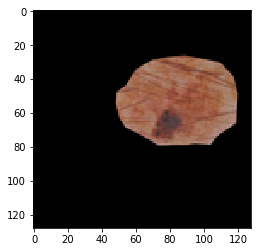

benign


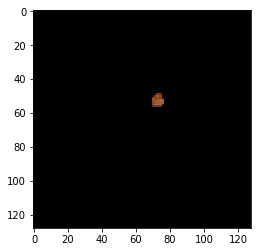

benign


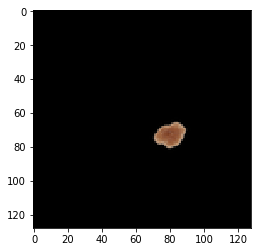

benign


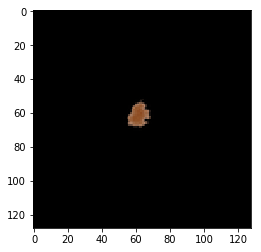

benign


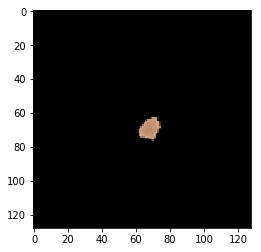

malignant


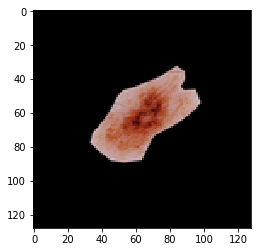

malignant


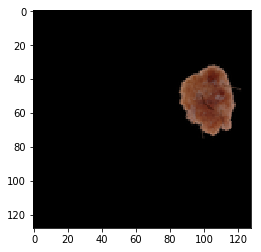

malignant


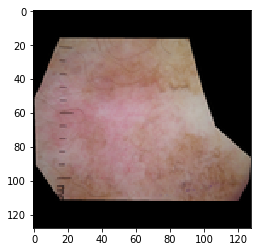

In [7]:
for i in range(8):
    print('benign' if y[i*500-1]==0 else 'malignant')
    plt.imshow(X[i*500-1])
    plt.show()

In [9]:
X_mean, X_std = (np.mean(X,axis=(0,1,2)),np.std(X,axis=(0,1,2)))

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                   test_size = 0.2, 
                                   random_state = 2018)

In [11]:
X_train_s = X_train.copy()
X_test_s = X_test.copy()
for i in range(3):
    X_train_s[:,:,:,i] = (X_train[:,:,:,i] - X_mean[i])/X_std[i]
    X_test_s[:,:,:,i] = (X_test[:,:,:,i] - X_mean[i])/X_std[i]

In [12]:
gen = keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True, vertical_flip=True, shear_range=0.1, zoom_range=0.1, rotation_range=45,fill_mode="constant")

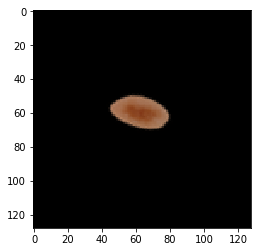

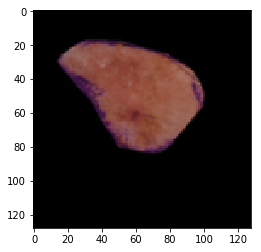

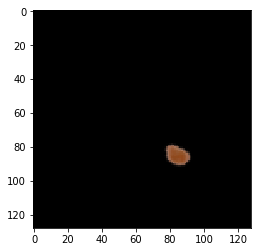

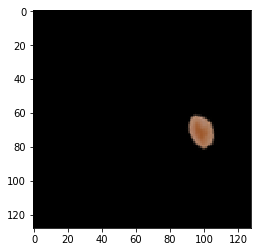

In [13]:
samples,_ = gen.flow(X_train,y_train, batch_size=4)[0]
for i in range(4):
    plt.imshow(samples[i]/255)
    plt.show()

In [55]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(*img_size,3)))
model.add(keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(2, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 32, 32, 64)        0         
__________

In [56]:
model.compile('adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
callbacks = [keras.callbacks.EarlyStopping(restore_best_weights = True, patience = 5),
            keras.callbacks.ModelCheckpoint('../models/keras_model.h5',save_best_only=True),
            TQDMNotebookCallback()]

In [57]:
batch_size = 64

In [58]:
history = model.fit_generator(
    gen.flow(X_train_s,y_train, batch_size=batch_size),epochs=30,
    callbacks = callbacks,
    validation_data=(X_test_s,y_test),
    workers=6,
    steps_per_epoch = len(X_train)//batch_size,
    verbose=0)

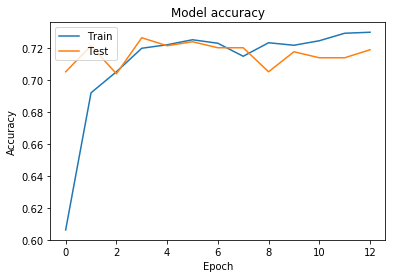

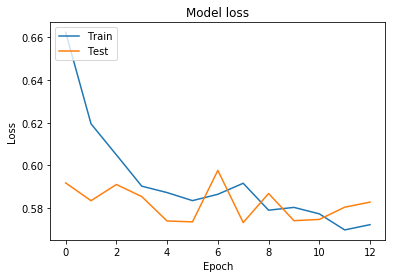

In [65]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [66]:
pd.DataFrame(history.history)

,val_loss,val_acc,loss,acc
0,0.591756,0.70500,0.662448,0.606250
1,0.583417,0.72125,0.619478,0.691875
2,0.591009,0.70375,0.604918,0.705000
3,0.585352,0.72625,0.590235,0.719688
4,0.573879,0.72125,0.587212,0.721875
5,0.573482,0.72375,0.583447,0.725000
6,0.597616,0.72000,0.586415,0.722812
7,0.573153,0.72000,0.591594,0.714688
8,0.586789,0.70500,0.578957,0.723125
9,0.574041,0.71750,0.580268,0.721562


In [67]:
model = keras.models.load_model('../models/keras_model.h5')

In [68]:
y_pred = model.predict_classes(X_test_s)

In [69]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.71      0.71      0.71       389
           1       0.73      0.73      0.73       411

   micro avg       0.72      0.72      0.72       800
   macro avg       0.72      0.72      0.72       800
weighted avg       0.72      0.72      0.72       800



In [64]:
y_pred.sum()

409